In [80]:
import csv
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap,shiftgrid

from matplotlib import colors as c
import xgboost as xgb

In [81]:
#读数据
filepath = 'https://power-analysis-ready-datastore.s3.amazonaws.com/power_901_monthly_radiation_utc.zarr'
filepath_mapped = fsspec.get_mapper(filepath)
ds = xr.open_zarr(store=filepath_mapped, consolidated=True)
ds

<xarray.Dataset>
Dimensions:                  (time: 468, lat: 180, lon: 360)
Coordinates:
  * lat                      (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                      (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * time                     (time) datetime64[ns] 1984-01-31 ... 2022-12-31
Data variables: (12/209)
    AIRMASS                  (time, lat, lon) float64 ...
    ALLSKY_KT                (time, lat, lon) float64 ...
    ALLSKY_KT_MAX            (time, lat, lon) float64 ...
    ALLSKY_KT_MIN            (time, lat, lon) float64 ...
    ALLSKY_KT_SD             (time, lat, lon) float64 ...
    ALLSKY_NKT               (time, lat, lon) float64 ...
    ...                       ...
    TOA_SW_DWN               (time, lat, lon) float64 ...
    TOA_SW_DWN_MAX           (time, lat, lon) float64 ...
    TOA_SW_DWN_MIN           (time, lat, lon) float64 ...
    TOA_SW_DWN_SD            (time, lat, lon) float64 ...
    TS_ADJ                   (time, lat, lon) float64 ...
    ZENITH_LUMINANCE         (time, lat, lon) float64 ...
Attributes: (12/37)
    acknowledgement:            The Prediction of Worldwide Energy Resources ...
    comment:                    Version 9.0.1 includes source data resolution.
    conventions:                CF-1.8, ACDD-1.3
    creator_email:              bradley.macpherson@nasa.gov
    creator_name:               Bradley Macpherson
    date_created:               2023-09-20T09:00:00.000000
    ...                         ...
    time_coverage_end:          2022-12-31T00:00:00
    time_coverage_resolution:   P1M
    time_coverage_start:        1984-01-01T00:00:00
    time_standard:              Universal Time Coordinated (UTC)
    title:                      POWER Monthly Radiation Time Series
    version:                    POWER Version 9.0.1

In [112]:
field_indices = [5, 6]  # 要选择的字段索引列表
filter_value = 'Solar'  # 筛选的数值
selected_data = []

with open('global_power_plant_database.csv', 'r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        if row[7] == filter_value:
            selected_row = [row[index] for index in field_indices]
            selected_data.append(selected_row)

label_array = np.array(selected_data)
rounded_array = np.array([[np.floor(num * 2) / 2 for num in row] for row in label_array.astype(float)])
rounded_array

array([[ 31.5,  65.5],
       [ 31.5,  65.5],
       [ 27.5,  -0.5],
       ...,
       [ 16. , 107.5],
       [ 11.5, 109. ],
       [-16. ,  28. ]])

In [117]:
rounded_array[:,0].shape

(10665,)

In [123]:
for i in rounded_array[:,0]:
    if i == -36.5:
        print('y')
index = np.argwhere(rounded_array[:,0]==-36.5)
print(index[0][0])

y
78


In [120]:
print(np.where(rounded_array[:,0] == float(-36.5)))

(array([78]),)


In [113]:
rounded_array.shape

(10665, 2)

In [83]:
# field_indices_w = [5, 6]  # 要选择的字段索引列表
# filter_value_w = 'Wind'  # 筛选的数值
# selected_data_w = []

# with open('global_power_plant_database.csv', 'r') as file:
#     csv_reader = csv.reader(file)
#     for row in csv_reader:
#         if row[7] == filter_value_w:
#             selected_row = [row[index] for index in field_indices_w]
#             selected_data_w.append(selected_row)

# label_array_w = np.array(selected_data_w)
# rounded_array_w = np.array([[np.floor(num * 2) / 2 for num in row] for row in label_array_w.astype(float)])
# rounded_array_w

In [84]:
# a1是每个点的ALLSKY_SFC_SW_DWN值从1984-2022求平均，a2同理
#特征含义请参考https://power.larc.nasa.gov/#resources
a1 = ds.ALLSKY_SFC_SW_DWN.fillna(0).mean(dim='time')
a2 = ds.ALLSKY_KT.fillna(0).mean(dim='time')
a3 = ds.DIRECT_ILLUMINANCE.fillna(0).mean(dim='time')
# a4 = ds.WS50M.fillna(0).mean(dim='time')
# a5 = np.abs(ds1.WD50M.fillna(0).diff(dim='time')).mean(dim='time')
# a6 = ds.TS_ADJ.fillna(0).mean(dim='time')
# a7 = ds1.V10M.fillna(0).mean(dim='time')
# a8 = ds1.V2M.fillna(0).mean(dim='time')
# a9 = ds1.V50M.fillna(0).mean(dim='time')
# a5 = ds.SNODP.fillna(0).mean(dim='time')
a4 = ds.TS_ADJ.fillna(0).mean(dim='time')
# a7 = ds.SLP.fillna(0).mean(dim='time')

#标准化
mi1 = np.min(a1)
ma1 = np.max(a1)
standardized_data1 = (a1 - mi1) / (ma1-mi1)

mi2 = np.min(a2)
ma2 = np.max(a2)
standardized_data2 = (a2 - mi2) / (ma2-mi2)

mi3 = np.min(a3)
ma3 = np.max(a3)
standardized_data3 = (a3 - mi3) / (ma3-mi3)

mi4 = np.min(a4)
ma4 = np.max(a4)
standardized_data4 = (a4 - mi4) / (ma4-mi4)


#简单搞个专家规则
feature = 0.7*standardized_data1 + 0.3*standardized_data2

lon = np.array(ds['lon'])
lat = np.array(ds['lat'])
# time = np.array(a['time'])
data = np.array(feature)

data1 = np.array(standardized_data1)
data2 = np.array(standardized_data2)
data3 = np.array(standardized_data3)
data4 = np.array(standardized_data4)
# data5 = np.array(standardized_data5)
# data6 = np.array(standardized_data6)
# data7 = np.array(standardized_data7)
# data8 = np.array(standardized_data8)
# data9 = np.array(standardized_data9)
# data10 = np.array(standardized_data10)
# data11 = np.array(standardized_data11)
# data12 = np.array(standardized_data12)

In [85]:
data_one1 = data1.flatten()
data_one1 = data_one1.reshape(-1,1)
data_one1
print(data_one1.shape)

data_one2 = data2.flatten()
data_one2 = data_one2.reshape(-1,1)
data_one2
print(data_one2.shape)

data_one3 = data3.flatten()
data_one3 = data_one3.reshape(-1,1)
data_one3
print(data_one3.shape)

data_one4 = data4.flatten()
data_one4 = data_one4.reshape(-1,1)
data_one4
print(data_one4.shape)


combined_array = np.concatenate((data_one1, data_one2,data_one3,data_one4), axis=1)
combined_array

(64800, 1)
(64800, 1)
(64800, 1)
(64800, 1)


array([[0.2878071 , 0.27864737, 0.20473719, 0.08636477],
       [0.2878071 , 0.27864737, 0.20473719, 0.08636477],
       [0.2878071 , 0.27864737, 0.20473719, 0.08636477],
       ...,
       [0.17129899, 0.13868872, 0.07205858, 0.44712158],
       [0.17129899, 0.13868872, 0.07205858, 0.44712158],
       [0.17129899, 0.13868872, 0.07205858, 0.44712158]])

In [86]:
grid_data = np.zeros(data.shape)
print(grid_data)
grid_data.shape

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(180, 360)

In [153]:
print(rounded_array[:,0])
print(rounded_array[:,1])
print(np.where(rounded_array[:,0] == -36.5))
print(rounded_array[:,0][78])
print(rounded_array[:,1][78])

[ 31.5  31.5  27.5 ...  16.   11.5 -16. ]
[ 65.5  65.5  -0.5 ... 107.5 109.   28. ]
(array([78]),)
-36.5
145.0


In [108]:
import numpy as np

rounded_array = np.array([[1, 2], [3, 4], [5, 6]])
row = 3

# 检查 rounded_array 中是否存在满足条件的元素
result = np.any(rounded_array[:, 0] == row)

print(rounded_array[:, 0])

[1 3 5]


In [170]:
i = 0
for row in lat:
    if np.any(rounded_array[:,0] == row):
        # print(row)      
        r = np.where(rounded_array[:,0] == row)[0][0]
        for col in lon: 
            # print(r)
            # print(rounded_array[:,0][r],rounded_array[:,1][r])
            # print(rounded_array[:,0][r])
            if rounded_array[:,1][r] == col:
                # print(col)
                # print(rounded_array[:,0][r],rounded_array[:,1][r])
                # print(rounded_array[:,0][r],rounded_array[:,1][r])
                lo = np.where(lat == row)[0][0]
                la = np.where(lon == col)[0][0]
                grid_data[lo][la] = int(1)
                i = i+1
# print(i)
# unique_values, counts = np.unique(rounded_array, return_counts=True)

# print(unique_values.shape)
# print(counts)

In [125]:
for row in lat:
    if np.any(rounded_array[:,0] == row):
        for col in lon: 
            if np.any(rounded_array[:,1] == col):
                lo = np.where(lat == row)[0][0]
                la = np.where(lon == col)[0][0]
                grid_data[lo][la] = int(1)
    # elif np.any(rounded_array_w[:,0] == row):
    #     for col in lon: 
    #         if np.any(rounded_array_w[:,1] == col):
    #             lo_w = np.where(lat == row)[0][0]
    #             la_w = np.where(lon == col)[0][0]
    #             grid_data[lo][la] = int(2)

In [131]:
np.where((rounded_array[:, 0] == 27.5) & (rounded_array[:, 1] == -0.5))

(array([2, 8]),)

In [88]:
grid_data_one = grid_data.flatten()
grid_data_one = grid_data_one.reshape(-1,1)
grid_data_one
# data_con_label = np.concatenate((combined_array, grid_data_one), axis=1)
# data_con_label

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [102]:
np.where(grid_data_one == 1)[0][0]

19100

In [89]:
combined_array

array([[0.2878071 , 0.27864737, 0.20473719, 0.08636477],
       [0.2878071 , 0.27864737, 0.20473719, 0.08636477],
       [0.2878071 , 0.27864737, 0.20473719, 0.08636477],
       ...,
       [0.17129899, 0.13868872, 0.07205858, 0.44712158],
       [0.17129899, 0.13868872, 0.07205858, 0.44712158],
       [0.17129899, 0.13868872, 0.07205858, 0.44712158]])

In [92]:
model = xgb.XGBClassifier(silent=True,learning_rate=0.01, max_depth=5, max_leaves=10, reg_alpha=0.1)

# 训练模型
model.fit(combined_array, grid_data_one)

/home/ec2-user/anaconda3/envs/Braket/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:47:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=10,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [13]:
#测试数据处理
# 全天空表面短波向下辐照度
ds_ALLSKY_SFC_SW_DWN_asian = ds.ALLSKY_SFC_SW_DWN.loc[:,-10:80,-25:170]
# 云量
ds_DIRECT_ILLUMINANCE_asian = ds.DIRECT_ILLUMINANCE.loc[:,-10:80,-25:170]
# 全天空日照晴朗指数
ds_ALLSKY_KT_asian = ds.ALLSKY_KT.loc[:,-10:80,-25:170]

In [11]:
predictions = model.predict(combined_array)

print(predictions)

[0 0 0 ... 0 0 0]


In [15]:
# a1是每个点的ALLSKY_SFC_SW_DWN值从1984-2022求平均，a2同理
#特征含义请参考https://power.larc.nasa.gov/#resources
a1 = ds.ALLSKY_SFC_SW_DWN.loc[:,-10:80,-25:170].fillna(0).mean(dim='time')
a2 = ds.ALLSKY_KT.loc[:,-10:80,-25:170].fillna(0).mean(dim='time')
a3 = ds.DIRECT_ILLUMINANCE.loc[:,-10:80,-25:170].fillna(0).mean(dim='time')
# a4 = ds.WS50M.fillna(0).mean(dim='time')
# a5 = np.abs(ds1.WD50M.fillna(0).diff(dim='time')).mean(dim='time')
# a6 = ds.TS_ADJ.fillna(0).mean(dim='time')
# a7 = ds1.V10M.fillna(0).mean(dim='time')
# a8 = ds1.V2M.fillna(0).mean(dim='time')
# a9 = ds1.V50M.fillna(0).mean(dim='time')
# a5 = ds.SNODP.fillna(0).mean(dim='time')
a4 = ds.TS_ADJ.loc[:,-10:80,-25:170].fillna(0).mean(dim='time')
# a7 = ds.SLP.fillna(0).mean(dim='time')

#标准化
mi1 = np.min(a1)
ma1 = np.max(a1)
standardized_data1 = (a1 - mi1) / (ma1-mi1)

mi2 = np.min(a2)
ma2 = np.max(a2)
standardized_data2 = (a2 - mi2) / (ma2-mi2)

mi3 = np.min(a3)
ma3 = np.max(a3)
standardized_data3 = (a3 - mi3) / (ma3-mi3)

mi4 = np.min(a4)
ma4 = np.max(a4)
standardized_data4 = (a4 - mi4) / (ma4-mi4)

# mi5 = np.min(a5)
# ma5 = np.max(a5)
# standardized_data5 = (a5 - mi5) / (ma4-mi5)

# mi6 = np.min(a6)
# ma6 = np.max(a6)
# standardized_data6 = (a6 - mi6) / (ma6-mi6)

# mi7 = np.min(a7)
# ma7 = np.max(a7)
# standardized_data7 = (a7 - mi7) / (ma7-mi7)

# mi8 = np.min(a8)
# ma8 = np.max(a8)
# standardized_data8 = (a8 - mi8) / (ma8-mi8)

# mi9 = np.min(a9)
# ma9 = np.max(a9)
# standardized_data9 = (a9 - mi9) / (ma9-mi9)

# mi10 = np.min(a10)
# ma10 = np.max(a10)
# standardized_data10 = (a10 - mi10) / (ma10-mi10)

# mi11 = np.min(a11)
# ma11 = np.max(a11)
# standardized_data11 = (a11 - mi11) / (ma11-mi11)

# mi12 = np.min(a12)
# ma12 = np.max(a12)
# standardized_data12 = (a12 - mi12) / (ma12-mi12)

#简单搞个专家规则
feature = 0.7*standardized_data1 + 0.3*standardized_data2

lon = np.array(ds['lon'])
lat = np.array(ds['lat'])
# time = np.array(a['time'])
data = np.array(feature)

data1 = np.array(standardized_data1)
data2 = np.array(standardized_data2)
data3 = np.array(standardized_data3)
data4 = np.array(standardized_data4)
# data5 = np.array(standardized_data5)
# data6 = np.array(standardized_data6)
# data7 = np.array(standardized_data7)
# data8 = np.array(standardized_data8)
# data9 = np.array(standardized_data9)
# data10 = np.array(standardized_data10)
# data11 = np.array(standardized_data11)
# data12 = np.array(standardized_data12)

In [18]:
data1.shape

(90, 195)

In [16]:
data_one1 = data1.flatten()
data_one1 = data_one1.reshape(-1,1)
data_one1
print(data_one1.shape)

data_one2 = data2.flatten()
data_one2 = data_one2.reshape(-1,1)
data_one2
print(data_one2.shape)

data_one3 = data3.flatten()
data_one3 = data_one3.reshape(-1,1)
data_one3
print(data_one3.shape)

data_one4 = data4.flatten()
data_one4 = data_one4.reshape(-1,1)
data_one4
print(data_one4.shape)

# data_one5 = data5.flatten()
# data_one5 = data_one5.reshape(-1,1)
# data_one5
# print(data_one5.shape)

# data_one6 = data6.flatten()
# data_one6 = data_one6.reshape(-1,1)
# data_one6
# print(data_one6.shape)

# data_one7 = data7.flatten()
# data_one7 = data_one7.reshape(-1,1)
# data_one7
# print(data_one7.shape)

# data_one8 = data8.flatten()
# data_one8 = data_one8.reshape(-1,1)
# data_one8
# print(data_one8.shape)

combined_array = np.concatenate((data_one1, data_one2,data_one3,data_one4), axis=1)
combined_array

(17550, 1)
(17550, 1)
(17550, 1)
(17550, 1)


array([[0.92788132, 0.85935758, 0.76488462, 0.84088709],
       [0.92358213, 0.85471746, 0.74802295, 0.83961113],
       [0.91729995, 0.84799108, 0.73711344, 0.8375778 ],
       ...,
       [0.16821966, 0.28448617, 0.1345913 , 0.16381805],
       [0.17087247, 0.29520521, 0.13587863, 0.16185922],
       [0.17087247, 0.29520521, 0.13587863, 0.16185922]])

In [17]:
predictions = model.predict(combined_array)

print(predictions)

[1 1 1 ... 0 0 0]


In [66]:
re = predictions.reshape(90,195)
print(re)

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 0 1 1]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [49]:
inxa = np.where(re == 1)
inxo = np.where(re == 1)

print(inxa[0])
print(inxo[1])

[ 0  0  0 ... 68 68 68]
[ 0  1  2 ... 44 45 46]


In [57]:
#[:,-10:80,-25:170]
print(lat.shape)
zia = np.where(lat == -9.5)[0][0]
yia = np.where(lat == 80.5)[0][0]
zio = np.where(lon == -24.5)[0][0]
yio = np.where(lon == 170.5)[0][0]
print(zia)
print(yia)
print(zio)
print(yio)
lat_pa = lat[zia:yia]
lon_pa = lon[zio:yio]
print(lat_pa)
print(lon_pa)

(180,)
80
170
155
350
[-9.5 -8.5 -7.5 -6.5 -5.5 -4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5
  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5 15.5 16.5 17.5
 18.5 19.5 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5 28.5 29.5 30.5 31.5
 32.5 33.5 34.5 35.5 36.5 37.5 38.5 39.5 40.5 41.5 42.5 43.5 44.5 45.5
 46.5 47.5 48.5 49.5 50.5 51.5 52.5 53.5 54.5 55.5 56.5 57.5 58.5 59.5
 60.5 61.5 62.5 63.5 64.5 65.5 66.5 67.5 68.5 69.5 70.5 71.5 72.5 73.5
 74.5 75.5 76.5 77.5 78.5 79.5]
[-24.5 -23.5 -22.5 -21.5 -20.5 -19.5 -18.5 -17.5 -16.5 -15.5 -14.5 -13.5
 -12.5 -11.5 -10.5  -9.5  -8.5  -7.5  -6.5  -5.5  -4.5  -3.5  -2.5  -1.5
  -0.5   0.5   1.5   2.5   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5
  11.5  12.5  13.5  14.5  15.5  16.5  17.5  18.5  19.5  20.5  21.5  22.5
  23.5  24.5  25.5  26.5  27.5  28.5  29.5  30.5  31.5  32.5  33.5  34.5
  35.5  36.5  37.5  38.5  39.5  40.5  41.5  42.5  43.5  44.5  45.5  46.5
  47.5  48.5  49.5  50.5  51.5  52.5  53.5  54.5  55.5  56.5  57.5  58.5
  59.5  6

In [69]:
print(inxa[0])
a = [lat_pa[i] for i in inxa[0]]
b = [lon_pa[i] for i in inxo[1]]

[ 0  0  0 ... 68 68 68]


In [76]:
print(data.shape)
print(lon_pa.shape)

(90, 195)
(195,)


/tmp/ipykernel_8452/2760463243.py:26: UserWarning: The following kwargs were not used by contour: 'shading'
  cs = map.contourf(x,y,VO, cmap=cmap, norm=norm, levels=bounds,shading='interp')


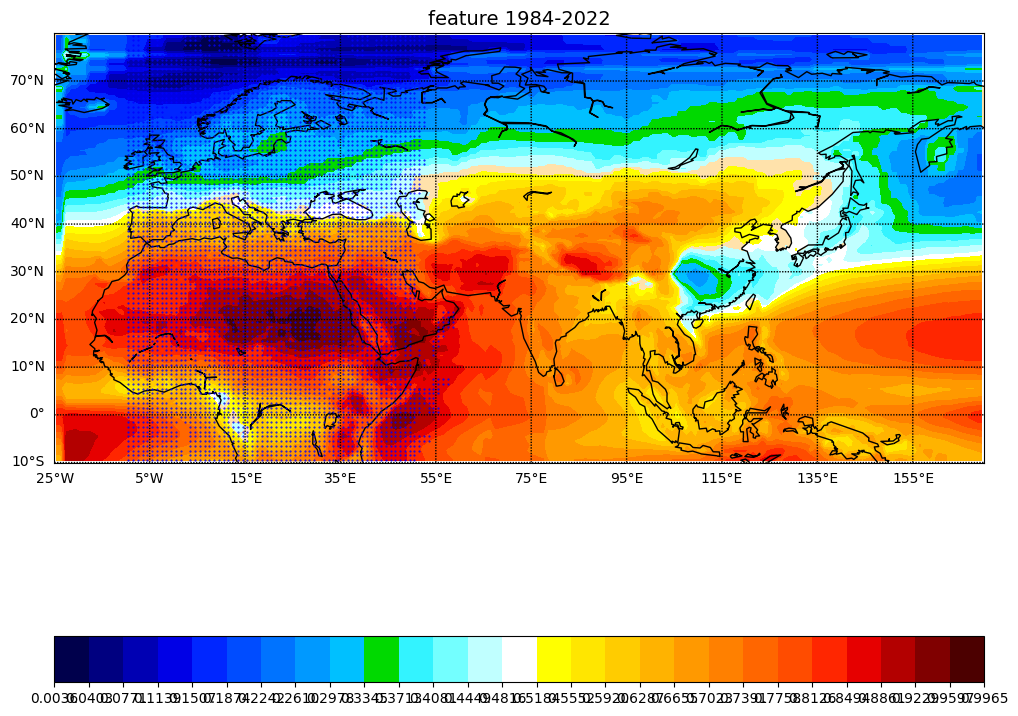

In [79]:
#这是化全球范围的图
fig = plt.figure(figsize=[12,15])  # 新窗口
ax = fig.add_subplot(1, 1, 1)  # 添加子图
ax.set_title('feature 1984-2022', fontsize=14)
 
map = Basemap(projection='cyl',llcrnrlat=-10,urcrnrlat=80, llcrnrlon=-25,urcrnrlon=170,resolution='c', ax=ax)
map.drawcoastlines()
map.fillcontinents(color='#ffe2ab')
# 添加经纬度
map.drawparallels(np.arange(-10.,80.,10.),labels=[1,0,0,0])
map.drawmeridians(np.arange(-25.,170.,20.),labels=[0,0,0,1])
map.plot(a,b, 'bo', markersize=0.5) 
# 经度范围设置为[-180,180]
VO, lons = shiftgrid(169.,data,lon_pa,start=False)
llons, llats = np.meshgrid(lon_pa, lat_pa)
x,y = map(llons,llats)
# 设置色阶
cmap = c.ListedColormap(['#00004c','#000080','#0000b3','#0000e6','#0026ff','#004cff',
                         '#0073ff','#0099ff','#00c0ff','#00d900','#33f3ff','#73ffff','#c0ffff', 
                         (0,0,0,0),
                         '#ffff00','#ffe600','#ffcc00','#ffb300','#ff9900','#ff8000','#ff6600',
                         '#ff4c00','#ff2600','#e60000','#b30000','#800000','#4c0000'])
bounds=np.linspace(data.min(),data.max(),28)
# bounds=[0,100,200,300,400,500,600,700,800,1000]
norm = c.BoundaryNorm(bounds, ncolors=cmap.N) 
cs = map.contourf(x,y,VO, cmap=cmap, norm=norm, levels=bounds,shading='interp')
# 添加颜色条
fig.colorbar(cs, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, ax=ax, orientation='horizontal')